# Projeto 02

**Alunos:**

Lucas Amin

Rafael Toyomoto


In [31]:
# importa os pacotes necessários
import time
import numpy as np
import os, cv2, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 


from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import  cross_val_score

from skimage import exposure
from skimage import feature

from skimage.feature import greycomatrix, greycoprops
from skimage.feature import hog

### Funções auxiliares

In [21]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

def read_image(file_path, rows=32, cols=32, colors=True):
    img =  cv2.imread(file_path, cv2.IMREAD_COLOR if colors else cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (rows, cols), interpolation=cv2.INTER_CUBIC)

def prep_data(images, rows=32, cols=32, colors=True):
    n_imgs = len(images)
    data = []
    
    printProgressBar(0, n_imgs, prefix='Loading images ...:', suffix='Complete', length=50)
    
    for i, image_file in enumerate(images):
        image = read_image(image_file, rows=rows, cols=cols, colors=colors)
        data.append(image)
        if i % 250:
            printProgressBar(i + 1, n_imgs, prefix='Loading images ...:', suffix='Complete', length=50)
    return data

### Descritores ([link](https://scikit-image.org/docs/dev/api/skimage.feature.html))

In [34]:
# dois exemplos de descritores. Você deve criar outros mais robustos.
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):     
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    #image = cv2.imread(image_file)        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()

def describe_hog(image):
    (H, hogImage) = feature.hog(image,
                                orientations=9,
                                pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2),
                                transform_sqrt=True,
                                block_norm="L1",
                                visualize=True)
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")
    return hogImage.flatten()

In [4]:
TRAIN_DIR = 'C:/Users/Avell/Documents/Dataset/cifar10/train/'
TRAIN_LBL = 'C:/Users/Avell/Documents/Dataset/cifar10/trainLabels.csv'

IMG_ROWS = 32
IMG_COLS = 32

In [5]:
# Carregar nome das imagens existentes
train_imgs_name = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_imgs = prep_data(train_imgs_name, rows=IMG_ROWS, cols=IMG_COLS, colors=True)

Loading images ...: |--------------------------------------------------| 0.3% Complete

Loading images ...: |███-----------------------------------------------| 7.8% Complete

Loading images ...: |██████--------------------------------------------| 12.2% Complete

Loading images ...: |█████████-----------------------------------------| 18.2% Complete

Loading images ...: |█████████-----------------------------------------| 18.5% Complete

Loading images ...: |█████████-----------------------------------------| 18.9% Complete

Loading images ...: |██████████████------------------------------------| 28.3% Complete

Loading images ...: |██████████████------------------------------------| 29.0% Complete

Loading images ...: |██████████████------------------------------------| 29.8% Complete

Loading images ...: |███████████████-----------------------------------| 30.6% Complete

Loading images ...: |█████████████████---------------------------------| 35.3% Complete

Loading images ...: |██████████████████--------------------------------| 37.6% Complete

Loading images ...: |███████████████████-------------------------------| 38.2% Complete

Loading images ...: |███████████████████████---------------------------| 47.6% Complete

Loading images ...: |████████████████████████████----------------------| 57.7% Complete

Loading images ...: |█████████████████████████████---------------------| 58.0% Complete

Loading images ...: |█████████████████████████████████-----------------| 66.6% Complete

Loading images ...: |███████████████████████████████████---------------| 71.0% Complete

Loading images ...: |████████████████████████████████████--------------| 72.1% Complete

Loading images ...: |█████████████████████████████████████-------------| 75.9% Complete

Loading images ...: |██████████████████████████████████████------------| 76.3% Complete

Loading images ...: |██████████████████████████████████████------------| 76.5% Complete

Loading images ...: |█████████████████████████████████████████---------| 83.2% Complete

Loading images ...: |███████████████████████████████████████████-------| 86.4% Complete

Loading images ...: |██████████████████████████████████████████████████| 100.0% Complete


In [7]:
# Carregar relação número da imagem com o label
train_data = pd.read_csv(TRAIN_LBL)
print("Labels: [" + "] [".join(train_data.label.unique()) + ']')

Labels: [frog] [truck] [deer] [automobile] [bird] [horse] [ship] [cat] [dog] [airplane]


In [8]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    labels = pd.DataFrame()
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        labels = pd.concat([df, dummies], axis=1)
    return labels

labels_onehot = one_hot(train_data,['label'])
del labels_onehot['label']
del labels_onehot['id']

print(labels_onehot.columns)

labels_onehot

Index(['label_airplane', 'label_automobile', 'label_bird', 'label_cat',
       'label_deer', 'label_dog', 'label_frog', 'label_horse', 'label_ship',
       'label_truck'],
      dtype='object')


label_airplane  label_automobile  label_bird  label_cat  label_deer  \
0                   0                 0           0          0           0   
1                   0                 0           0          0           0   
2                   0                 0           0          0           0   
3                   0                 0           0          0           1   
4                   0                 1           0          0           0   
...               ...               ...         ...        ...         ...   
49995               0                 0           1          0           0   
49996               0                 0           0          0           0   
49997               0                 0           0          0           0   
49998               0                 1           0          0           0   
49999               0                 1           0          0           0   

       label_dog  label_frog  label_horse  label_ship  label_truck  
0              0           1            0           0            0  
1              0           0            0           0            1  
2              0           0            0           0            1  
3              0           0            0           0            0  
4              0           0            0           0            0  
...          ...         ...          ...         ...          ...  
49995          0           0            0           0            0  
49996          0           1            0           0            0  
49997          0           0            0           0            1  
49998          0           0            0           0            0  
49999          0           0            0           0            0  

[50000 rows x 10 columns]

In [19]:
rawImages = []
descHist = []

count = len(train_imgs)

for i, image in enumerate(train_imgs):
    pixels = image_to_feature_vector(image)
    histogram = extract_color_histogram(image)
    
    rawImages.append(pixels)
    descHist.append(histogram)
        
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

Processed 0 of 50000
Processed 1000 of 50000
Processed 2000 of 50000
Processed 3000 of 50000
Processed 4000 of 50000
Processed 5000 of 50000
Processed 6000 of 50000
Processed 7000 of 50000
Processed 8000 of 50000
Processed 9000 of 50000
Processed 10000 of 50000
Processed 11000 of 50000
Processed 12000 of 50000
Processed 13000 of 50000
Processed 14000 of 50000
Processed 15000 of 50000
Processed 16000 of 50000
Processed 17000 of 50000
Processed 18000 of 50000
Processed 19000 of 50000
Processed 20000 of 50000
Processed 21000 of 50000
Processed 22000 of 50000
Processed 23000 of 50000
Processed 24000 of 50000
Processed 25000 of 50000
Processed 26000 of 50000
Processed 27000 of 50000
Processed 28000 of 50000
Processed 29000 of 50000
Processed 30000 of 50000
Processed 31000 of 50000
Processed 32000 of 50000
Processed 33000 of 50000
Processed 34000 of 50000
Processed 35000 of 50000
Processed 36000 of 50000
Processed 37000 of 50000
Processed 38000 of 50000
Processed 39000 of 50000
Processed 400

In [20]:
# Preparar os dados a serem utilizados
crop=5000

labels_value = labels_onehot.values
labels_text = train_data["label"].values

if 0 < crop < len(rawImages):
    rawImages = rawImages[:crop]
    descHist = descHist[:crop]
    labels_value = labels_value[:crop]
    labels_text = labels_text[:crop]

# Visualizar

AttributeError: module 'cv2.cv2' has no attribute 'reshape'

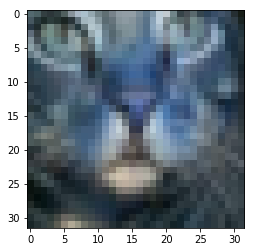

In [38]:

#describe_hog

test_number = 10
plt.imshow(train_imgs[test_number])

teste = describe_hog(train_imgs[test_number])

teste
plt.imshow(cv2.reshape(teste, (32,32)))


In [ ]:
#Avalia a combinação dos dois primeiros descritores!

#ATENÇÃO: ESTE É APENAS UM CÓDIGO EXEMPLO. VOCÊ DEVE DESENVOLVER
#DESCRITORES MAIS ROBUSTOS, BEM COMO EXPLORAR MELHOR AS MÉTRICAS
#DE AVALIAÇÃO (MATRIZ DE CONFUSÃO, ETC)

trainAux = np.hstack((descHist, rawImages))
(X_train, X_test, y_train, y_test) = train_test_split(trainAux, labels_text, test_size=0.25, random_state=42)

classifiers = [
    KNeighborsClassifier(17),    
    DecisionTreeClassifier(),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))   

KNeighborsClassifier
****Results****


In [17]:
#Avalia o primeiro descritor: as imagens raw

(X_train, X_test, y_train, y_test) = train_test_split(rawImages, labels_text, test_size=0.10, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print("DecisionTreeClassifier:")
train_predictions = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("accuracy: {:.2f}%".format(acc * 100))


DecisionTreeClassifier:
accuracy: 10.00%


In [16]:
#Avalia o segundo descritor: color histogram

(X_train, X_test, y_train, y_test) = train_test_split(descHist, labels_text, test_size=0.25, random_state=42)
classifiers = [KNeighborsClassifier(17), DecisionTreeClassifier(), GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))   

KNeighborsClassifier
****Results****
accuracy: 9.98%
DecisionTreeClassifier
****Results****
accuracy: 10.30%
GaussianNB
****Results****
accuracy: 10.08%
